In [1]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
tweets = pd.read_csv('data_elonmusk.csv', encoding = 'unicode_escape')
tweets = tweets.assign(Time=pd.to_datetime(tweets.Time)).drop('row ID', axis='columns')

print("Number of tweets: ",len(tweets['Tweet']))
tweets.head(5)

Number of tweets:  3218


,Tweet,Time,Retweet from,User
0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [4]:
tweets['Time'] = pd.to_datetime(tweets['Time'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['Time']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Years',
    height=450,
    width=1200,
    xaxis=dict(
        title='Month and year'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [5]:
# Prep the corpus

corpus=[]
a=[]
for i in range(len(tweets['Tweet'])):
        a=tweets['Tweet'][i]
        corpus.append(a)
        
corpus[0:10]

["@MeltingIce Assuming max acceleration of 2 to 3 g's, but in a comfortable direction. Will feel like a mild to moder? https://t.co/fpjmEgrHfC",
 'RT @SpaceX: BFR is capable of transporting satellites to orbit, crew and cargo to the @Space_Station and completing missions to the Moon an?',
 '@bigajm Yup :)',
 'Part 2 https://t.co/8Fvu57muhM',
 'Fly to most places on Earth in under 30 mins and anywhere in under 60. Cost per seat should be? https://t.co/dGYDdGttYd',
 'RT @SpaceX: Supporting the creation of a permanent, self-sustaining human presence on Mars. https://t.co/kCtBLPbSg8 https://t.co/ra6hKsrOcG',
 'BFR will take you anywhere on Earth in less than 60 mins https://t.co/HWt9BZ1FI9',
 'Mars City\nOpposite of Earth. Dawn and dusk sky are blue on Mars and day sky is red. https://t.co/XHcZIdgqnb',
 'Moon Base Alpha https://t.co/voY8qEW9kl',
 "Will be announcing something really special at today's talk https://t.co/plXTBJY6ia"]

In [6]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/var/folders/04/76dktb_j6hj2qq9tx78jrzyc0000gp/T" will be used to save temporary dictionary and corpus.


In [9]:
import nltk
nltk.download('stopwords')

# Remove the Retweet indicator and other stop words removing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lmcquillan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2019-10-22 10:28:06,978 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-22 10:28:07,022 : INFO : built Dictionary(11842 unique tokens: ['2', '3', '@meltingice', 'acceleration', 'assuming']...) from 3218 documents (total 30256 corpus positions)
2019-10-22 10:28:07,022 : INFO : saving Dictionary object under /var/folders/04/76dktb_j6hj2qq9tx78jrzyc0000gp/T/elon.dict, separately None
2019-10-22 10:28:07,026 : INFO : saved /var/folders/04/76dktb_j6hj2qq9tx78jrzyc0000gp/T/elon.dict


In [10]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)

2019-10-22 10:28:22,770 : INFO : storing corpus in Matrix Market format to /var/folders/04/76dktb_j6hj2qq9tx78jrzyc0000gp/T/elon.mm
2019-10-22 10:28:22,771 : INFO : saving sparse matrix to /var/folders/04/76dktb_j6hj2qq9tx78jrzyc0000gp/T/elon.mm
2019-10-22 10:28:22,772 : INFO : PROGRESS: saving document #0
2019-10-22 10:28:22,787 : INFO : PROGRESS: saving document #1000
2019-10-22 10:28:22,803 : INFO : PROGRESS: saving document #2000
2019-10-22 10:28:22,821 : INFO : PROGRESS: saving document #3000
2019-10-22 10:28:22,826 : INFO : saved 3218x11842 matrix, density=0.079% (29959/38107556)
2019-10-22 10:28:22,827 : INFO : saving MmCorpus index to /var/folders/04/76dktb_j6hj2qq9tx78jrzyc0000gp/T/elon.mm.index


In [11]:
tfidf = models.TfidfModel(corpus)

2019-10-22 10:28:32,394 : INFO : collecting document frequencies
2019-10-22 10:28:32,395 : INFO : PROGRESS: processing document #0
2019-10-22 10:28:32,402 : INFO : calculating IDF weights for 3218 documents and 11842 features (29959 matrix non-zeros)


In [12]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [13]:
total_topics = 5

In [14]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2019-10-22 10:28:59,722 : INFO : using symmetric alpha at 0.2
2019-10-22 10:28:59,723 : INFO : using symmetric eta at 0.2
2019-10-22 10:28:59,725 : INFO : using serial LDA version on this node
2019-10-22 10:28:59,732 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 3218 documents, updating model once every 2000 documents, evaluating perplexity every 3218 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-22 10:28:59,733 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-22 10:28:59,734 : INFO : PROGRESS: pass 0, at document #2000/3218
2019-10-22 10:29:00,485 : INFO : merging changes from 2000 documents into a model of 3218 documents
2019-10-22 10:29:00,489 : INFO : topic #0 (0.200): 0.005*"car" + 0.004*"model" + 0.004*"tesla" + 0.004*"like" + 0.004*"@spacex" + 0.003*"that's" + 0.003*"love" + 0.003*"next" + 0.003*"..." + 0.003

In [15]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.007*"tesla" + 0.005*"car" + 0.004*"model" + 0.004*"@spacex" + 0.004*"like"'),
 (1,
  '0.007*"tesla" + 0.004*"model" + 0.004*"need" + 0.004*"next" + 0.003*"w"'),
 (2,
  '0.010*"tesla" + 0.009*"launch" + 0.008*"falcon" + 0.008*"model" + 0.007*"rocket"'),
 (3,
  '0.010*"tesla" + 0.006*"model" + 0.006*"like" + 0.006*"@teslamotors:" + 0.004*"would"'),
 (4,
  '0.007*"tesla" + 0.007*"rocket" + 0.007*"model" + 0.007*"@spacex:" + 0.005*"launch"')]

In [16]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [17]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 80)


2019-10-22 10:29:44,377 : INFO : Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2019-10-22 10:29:44,378 : INFO : NumExpr defaulting to 8 threads.


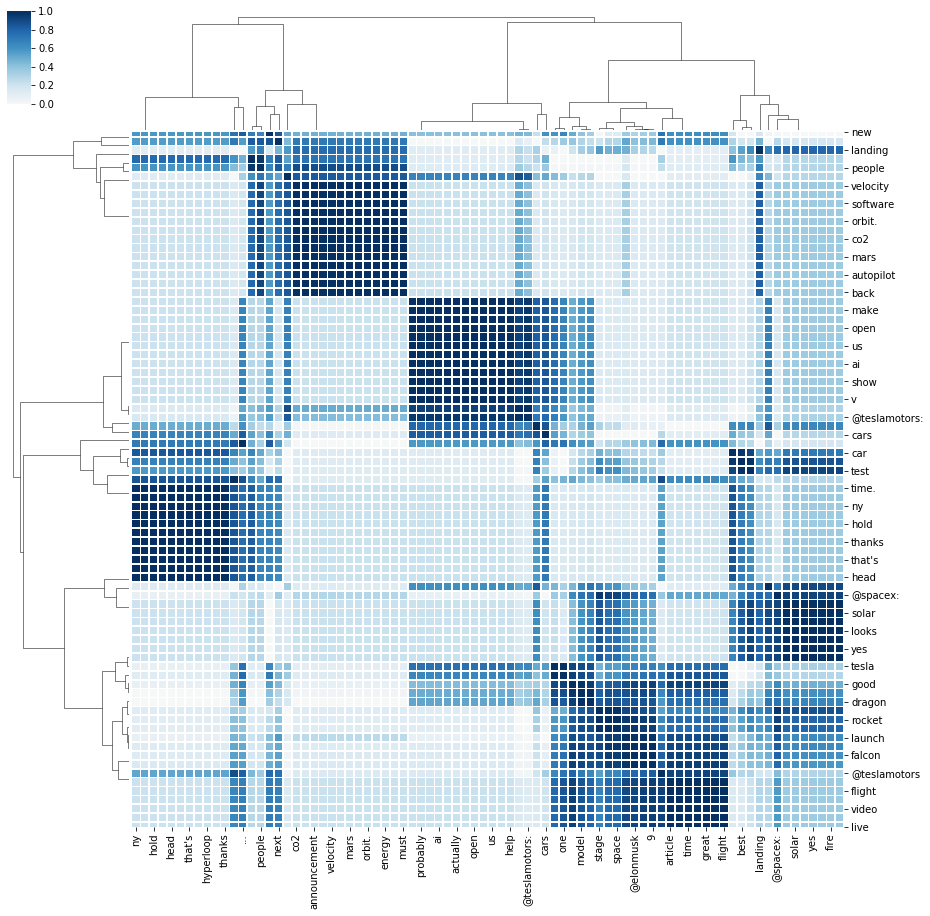

In [18]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [19]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2       3.501776  -4.736882       1        1  37.530281
3      56.768093  -4.530620       2        1  32.032818
4     -20.292397 -54.617275       3        1  10.234882
0      30.367020 -71.571190       4        1  10.106380
1      80.900269 -54.250313       5        1  10.095642, topic_info=     Category       Freq    Term      Total  loglift  logprob
90    Default  13.000000  rocket  13.000000  30.0000  30.0000
329   Default  14.000000  launch  14.000000  29.0000  29.0000
82    Default  12.000000  falcon  12.000000  28.0000  28.0000
...       ...        ...     ...        ...      ...      ...
1397   Topic5   0.491902  almost   2.247643   0.7737  -6.4929
286    Topic5   0.492404    test   4.244298   0.1390  -6.4919
957    Topic5   0.491217    cars   4.197271   0.1478  -6.4943

[367 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1013      3  0.974864  #dragon
272       1  0.403258      ...
272       2  0.268839      ...
...     ...       ...      ...
144       2  0.552417     yes,
2695      2  0.941763     yet.
5608      1  0.966858     york

[312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])